# 1 Quizz

# 2 Image classification

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

import matplotlib.image as mpimg
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras

## Creation des dataset Train et Validation

In [2]:
# Catégories à traiter
categories = ['Colonial', 'Modern', 'Prehispanic']
train_dir = 'MexCulture142/images_train'
validation_dir = 'MexCulture142/images_val'

# Créer les répertoires d'entraînement et de validation pour chaque catégorie
for category in categories:
    # Répertoires d'entraînement
    train_category_dir = os.path.join(train_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    
    # Répertoires de validation
    validation_category_dir = os.path.join(validation_dir, category)
    os.makedirs(validation_category_dir, exist_ok=True)

# Répertoires de classes dans train_dir
train_colonial_dir = os.path.join(train_dir, 'Colonial')
train_modern_dir = os.path.join(train_dir, 'Modern')
train_prehispanic_dir = os.path.join(train_dir, 'Prehispanic')

# Répertoires de classes dans validation_dir
validation_colonial_dir = os.path.join(validation_dir, 'Colonial')
validation_modern_dir = os.path.join(validation_dir, 'Modern')
validation_prehispanic_dir = os.path.join(validation_dir, 'Prehispanic')

In [3]:
# Fonction pour déplacer les images
def move_images(directory, colonial_dir, modern_dir, prehispanic_dir):
    for filename in os.listdir(directory):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Extraire le suffixe (la première partie avant l'underscore '_')
            suffix = filename.split('_')[0]
            
            # Déplacer l'image dans le bon répertoire
            if suffix == 'Colonial':
                shutil.move(os.path.join(directory, filename), os.path.join(colonial_dir, filename))
            elif suffix == 'Modern':
                shutil.move(os.path.join(directory, filename), os.path.join(modern_dir, filename))
            elif suffix == 'Prehispanic':
                shutil.move(os.path.join(directory, filename), os.path.join(prehispanic_dir, filename))

# Déplacer les images dans les sous-dossiers appropriés
move_images(train_dir, train_colonial_dir, train_modern_dir, train_prehispanic_dir)
move_images(validation_dir, validation_colonial_dir, validation_modern_dir, validation_prehispanic_dir)

# Vérifier le nombre d'images déplacées
print(f"There are {len(os.listdir(train_colonial_dir))} Colonial images for training.")
print(f"There are {len(os.listdir(train_modern_dir))} Modern images for training.")
print(f"There are {len(os.listdir(train_prehispanic_dir))} Prehispanic images for training.\n")

print(f"There are {len(os.listdir(validation_colonial_dir))} Colonial images for validation.")
print(f"There are {len(os.listdir(validation_modern_dir))} Modern images for validation.")
print(f"There are {len(os.listdir(validation_prehispanic_dir))} Prehispanic images for validation.")

There are 150 Colonial images for training.
There are 34 Modern images for training.
There are 52 Prehispanic images for training.

There are 16 Colonial images for validation.
There are 16 Modern images for validation.
There are 16 Prehispanic images for validation.


On peut voir que les classes sont très déséquilibrées, ce qui va mener le réseau de neurones à prédire Modern de façon aléatoire.

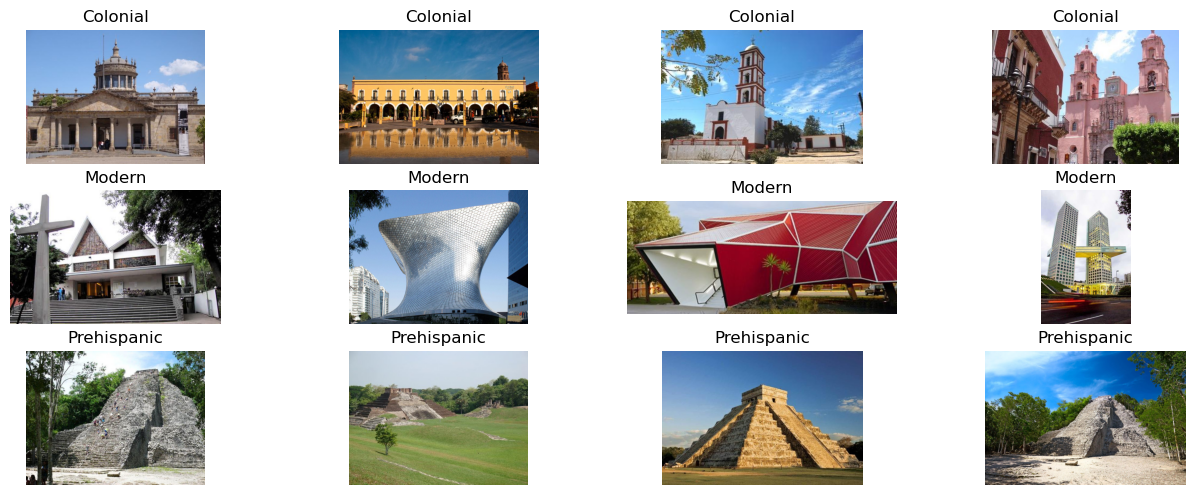

In [4]:
train_colonial_fnames = os.listdir(train_colonial_dir)
train_modern_fnames = os.listdir(train_modern_dir)
train_prehispanic_fnames = os.listdir(train_prehispanic_dir)

# Paramètres pour l'affichage
ncols = 4  # Nombre de colonnes
nrows = 2  # Nombre de lignes

# Créer la figure pour afficher les images
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# Spécifiez le nombre d'images à afficher par classe
num_images_per_class = 4

# Afficher les images de chaque classe
for class_idx, (class_dir, class_fnames, title) in enumerate(zip(
    [train_colonial_dir, train_modern_dir, train_prehispanic_dir],
    [train_colonial_fnames, train_modern_fnames, train_prehispanic_fnames],
    ['Colonial', 'Modern', 'Prehispanic']
)):
    # Sélectionner les images à afficher
    selected_fnames = class_fnames[:num_images_per_class]
    
    for i, fname in enumerate(selected_fnames):
        img_path = os.path.join(class_dir, fname)

        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(len(selected_fnames), ncols, class_idx * num_images_per_class + i + 1)
        sp.axis('Off')  # Ne pas afficher les axes (ou les lignes de grille)

        img = mpimg.imread(img_path)
        plt.imshow(img)
        sp.set_title(title)  # Ajouter le titre de la classe

plt.show()

In [5]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator(rescale=1./255
                                    )

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  return train_generator, validation_generator


In [6]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 236 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


## Création du Réseau de neurone

In [7]:
pre_trained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classifier_activation='softmax'
)
for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Nous avons récupéré le réseau ResNet50 car il est plus petit, donc plus adapté à notre petit dataset, et il a de très bonnes performances. Nous avons désactivé chaque couche de convolution car nous ne possédons pas un dataset assez gros pour modifier les poids. Nous avons enlevé les couches fully connected pour qu'il s'entraîne sur nos données.

In [8]:
def create_final_model(pre_trained_model, last_output):
    # Aplatir la couche de sortie
    x = layers.GlobalAveragePooling2D()(pre_trained_model.layers[-1].output)
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(3, activation='softmax')(x)

    # Créer le modèle complet
    model = Model(inputs=pre_trained_model.input, outputs=x)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [9]:
model = create_final_model(pre_trained_model, pre_trained_model.output)
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 28,309,379 total parameters in this model.
There are 4,721,667 trainable parameters in this model.


In [10]:
#Vu que les classes sont désequilibrié, soit il faut generer des images par classes,
#soit rajouter des poids au classe
class_weight = {
    0: 0.524,  # Colonial # 236/(150*3)
    1: 2.313,  # Modern # 236/(34*3)
    2: 1.512  # Prehispanic # 236/(52*3)
}


earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('bestModel.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

val_images, val_labels = next(iter(validation_generator)) 


history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 60,
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
                    verbose=2,
                    class_weight=class_weight)

Epoch 1/60


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 - 32s - 4s/step - accuracy: 0.3559 - loss: 1.1405 - val_accuracy: 0.3542 - val_loss: 1.0642 - learning_rate: 1.0000e-04
Epoch 2/60
8/8 - 24s - 3s/step - accuracy: 0.3390 - loss: 1.1398 - val_accuracy: 0.4167 - val_loss: 1.0614 - learning_rate: 1.0000e-04
Epoch 3/60
8/8 - 24s - 3s/step - accuracy: 0.4153 - loss: 1.1305 - val_accuracy: 0.5208 - val_loss: 1.0264 - learning_rate: 1.0000e-04
Epoch 4/60
8/8 - 24s - 3s/step - accuracy: 0.4322 - loss: 1.0738 - val_accuracy: 0.3333 - val_loss: 1.0400 - learning_rate: 1.0000e-04
Epoch 5/60
8/8 - 25s - 3s/step - accuracy: 0.3898 - loss: 1.0899 - val_accuracy: 0.4375 - val_loss: 1.0115 - learning_rate: 1.0000e-04
Epoch 6/60
8/8 - 24s - 3s/step - accuracy: 0.4873 - loss: 1.0523 - val_accuracy: 0.6042 - val_loss: 0.9791 - learning_rate: 1.0000e-04
Epoch 7/60
8/8 - 24s - 3s/step - accuracy: 0.4110 - loss: 1.0153 - val_accuracy: 0.5833 - val_loss: 0.9663 - learning_rate: 1.0000e-04
Epoch 8/60
8/8 - 24s - 3s/step - accuracy: 0.5975 - loss: 0.9775 -

## Performance

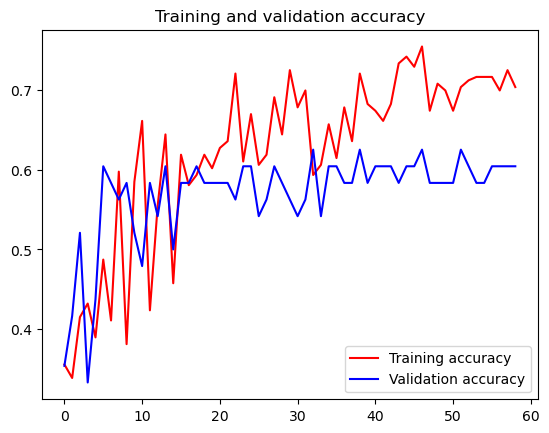

<Figure size 640x480 with 0 Axes>

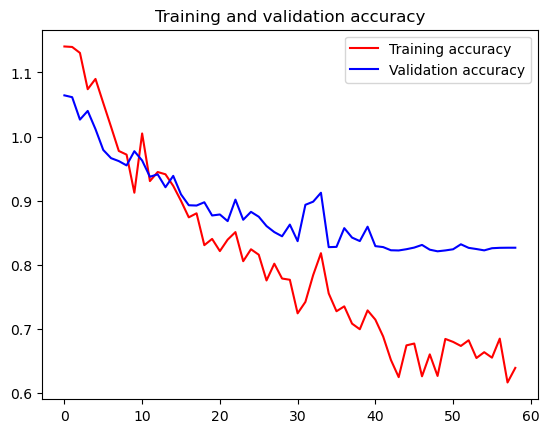

<Figure size 640x480 with 0 Axes>

In [11]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

On peut constater qu'il faut baisser le learning rate car il est en dents de scie

### Chargement du meilleur model de validation

In [12]:
model = keras.saving.load_model('bestModel.keras')

### Sur les données de validation

In [13]:
import numpy as np
from sklearn.metrics import classification_report

# Supposons que validation_generator est déjà défini
val_images, val_labels = next(iter(validation_generator))  # Obtenir un lot d'images et d'étiquettes de validation

# Faire des prédictions sur les données de validation
predictions = model.predict(val_images)

# Convertir les prédictions en classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(val_labels, axis=1)

report = classification_report(true_classes, predicted_classes, output_dict=True)

# Afficher l'accuracy pour chaque classe
for class_label, metrics in report.items():
    if isinstance(metrics, dict):  # Pour éviter les entrées non-classe comme 'accuracy' globale
        print(f"Classe {class_label}: Accuracy = {metrics['precision']:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classe 0: Accuracy = 0.33
Classe 1: Accuracy = 0.29
Classe 2: Accuracy = 0.67
Classe macro avg: Accuracy = 0.43
Classe weighted avg: Accuracy = 0.46


On peut voir que la classe Modern a toujours du malgrès les poids sur les classes ; ainsi, il aurait quand meme fallu augmenter le dataset

In [14]:
def is_image_in_list(image, image_list):
    for img in image_list:
        if np.array_equal(image, img[0]):
            return True
    return False

In [15]:
val_images, val_labels = next(iter(validation_generator)) 

# Faire des prédictions
predictions = model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(val_labels, axis=1)

# Identifier les prédictions incorrectes
wrong_predictions = []

def save_image(predictions_list, condition, comparator):
    for i in range(len(val_images)):
        if condition(predicted_classes[i], true_classes[i]):
            # Enregistrer l'image, la prédiction et le score d'exactitude
            accuracy = comparator(predictions[i])  # Utiliser les prédictions actuelles
            if not is_image_in_list(val_images[i], predictions_list):
                predictions_list.append((val_images[i], predicted_classes[i], accuracy))
    return predictions_list  # Correction pour retourner la liste des prédictions

# Utilisation des opérateurs pour les conditions
wrong_predictions = save_image(wrong_predictions, lambda pred, true: pred != true, np.max)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


_____Wrong Predictions_____


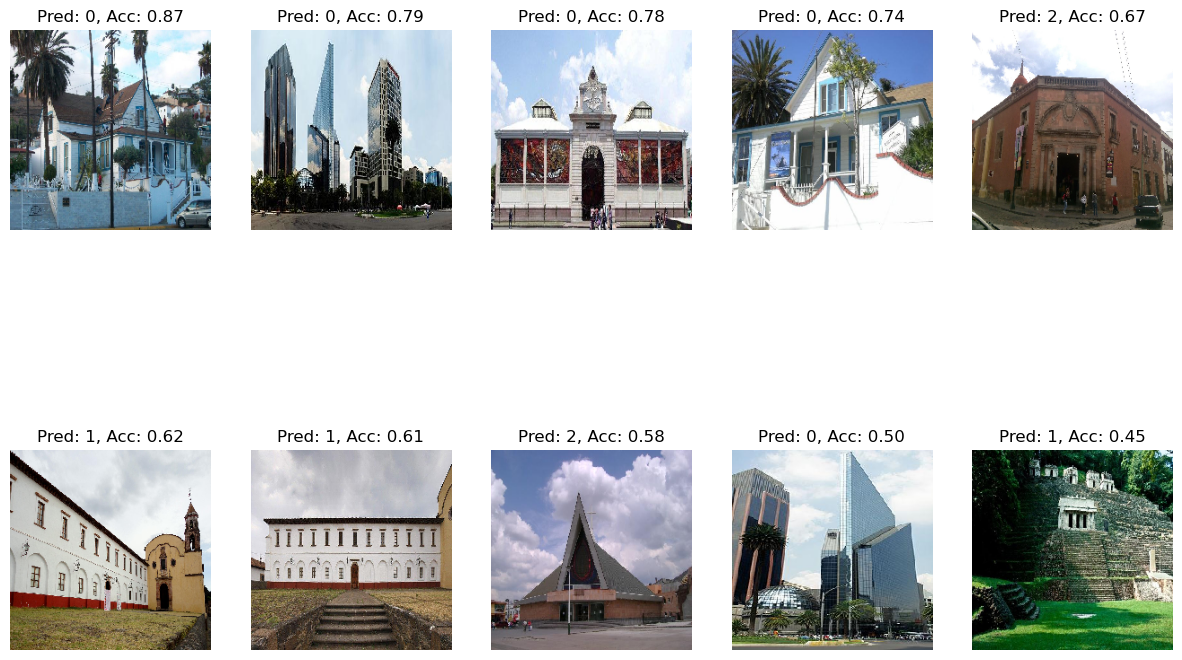

In [16]:
def plot_top_predictions(predictions, top_n=10):
    # Trier les prédictions par score
    predictions.sort(key=lambda x: x[2], reverse=True)  # Trier par précision

    # Afficher les images avec les scores les plus élevés
    plt.figure(figsize=(15, 10))
    for i in range(min(top_n, len(predictions))):  
        img, pred_class, accuracy = predictions[i]
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Pred: {pred_class}, Acc: {accuracy:.2f}')
        plt.axis('off')
    plt.show()

print("_____Wrong Predictions_____")
plot_top_predictions(wrong_predictions, top_n=10)